## Change Log
- ToDo: Update distance function within custom loss to use all features (instead of only using the distance of the predicted one)
- ToDo: Implement function to load input file with config parameters
- ToDo: Create output file with relevant experiment data
- cluster noise (-1 values) is no longer considered as a cluster in cluster_means

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN

## 0. Configuration Parameters
Customizing constants for the run(s).

In [2]:
# config
np.random.seed(23452346)

# Clustering DBSCAN hyperparameters
eps=3
min_samples=5

# RQ2 parameters
mv_percent = [0, 0.15, 0.10]   # percentages of missing values created in the feature columns
pred_features = 1              # percentage of features used to predict missing values (features will be randomly chosen)
runs = 1                       # number of prediction runs performed with the randomly chosen features

## 1. Datasets

### 1.0. Create or load dataset
As of now, only a toy dataset is used (3 features with 3 clusters centered around different points).

In [3]:
from sklearn.datasets import make_blobs

features_arr, clusters_arr = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

### 1.1. plot data

<IPython.core.display.Javascript object>


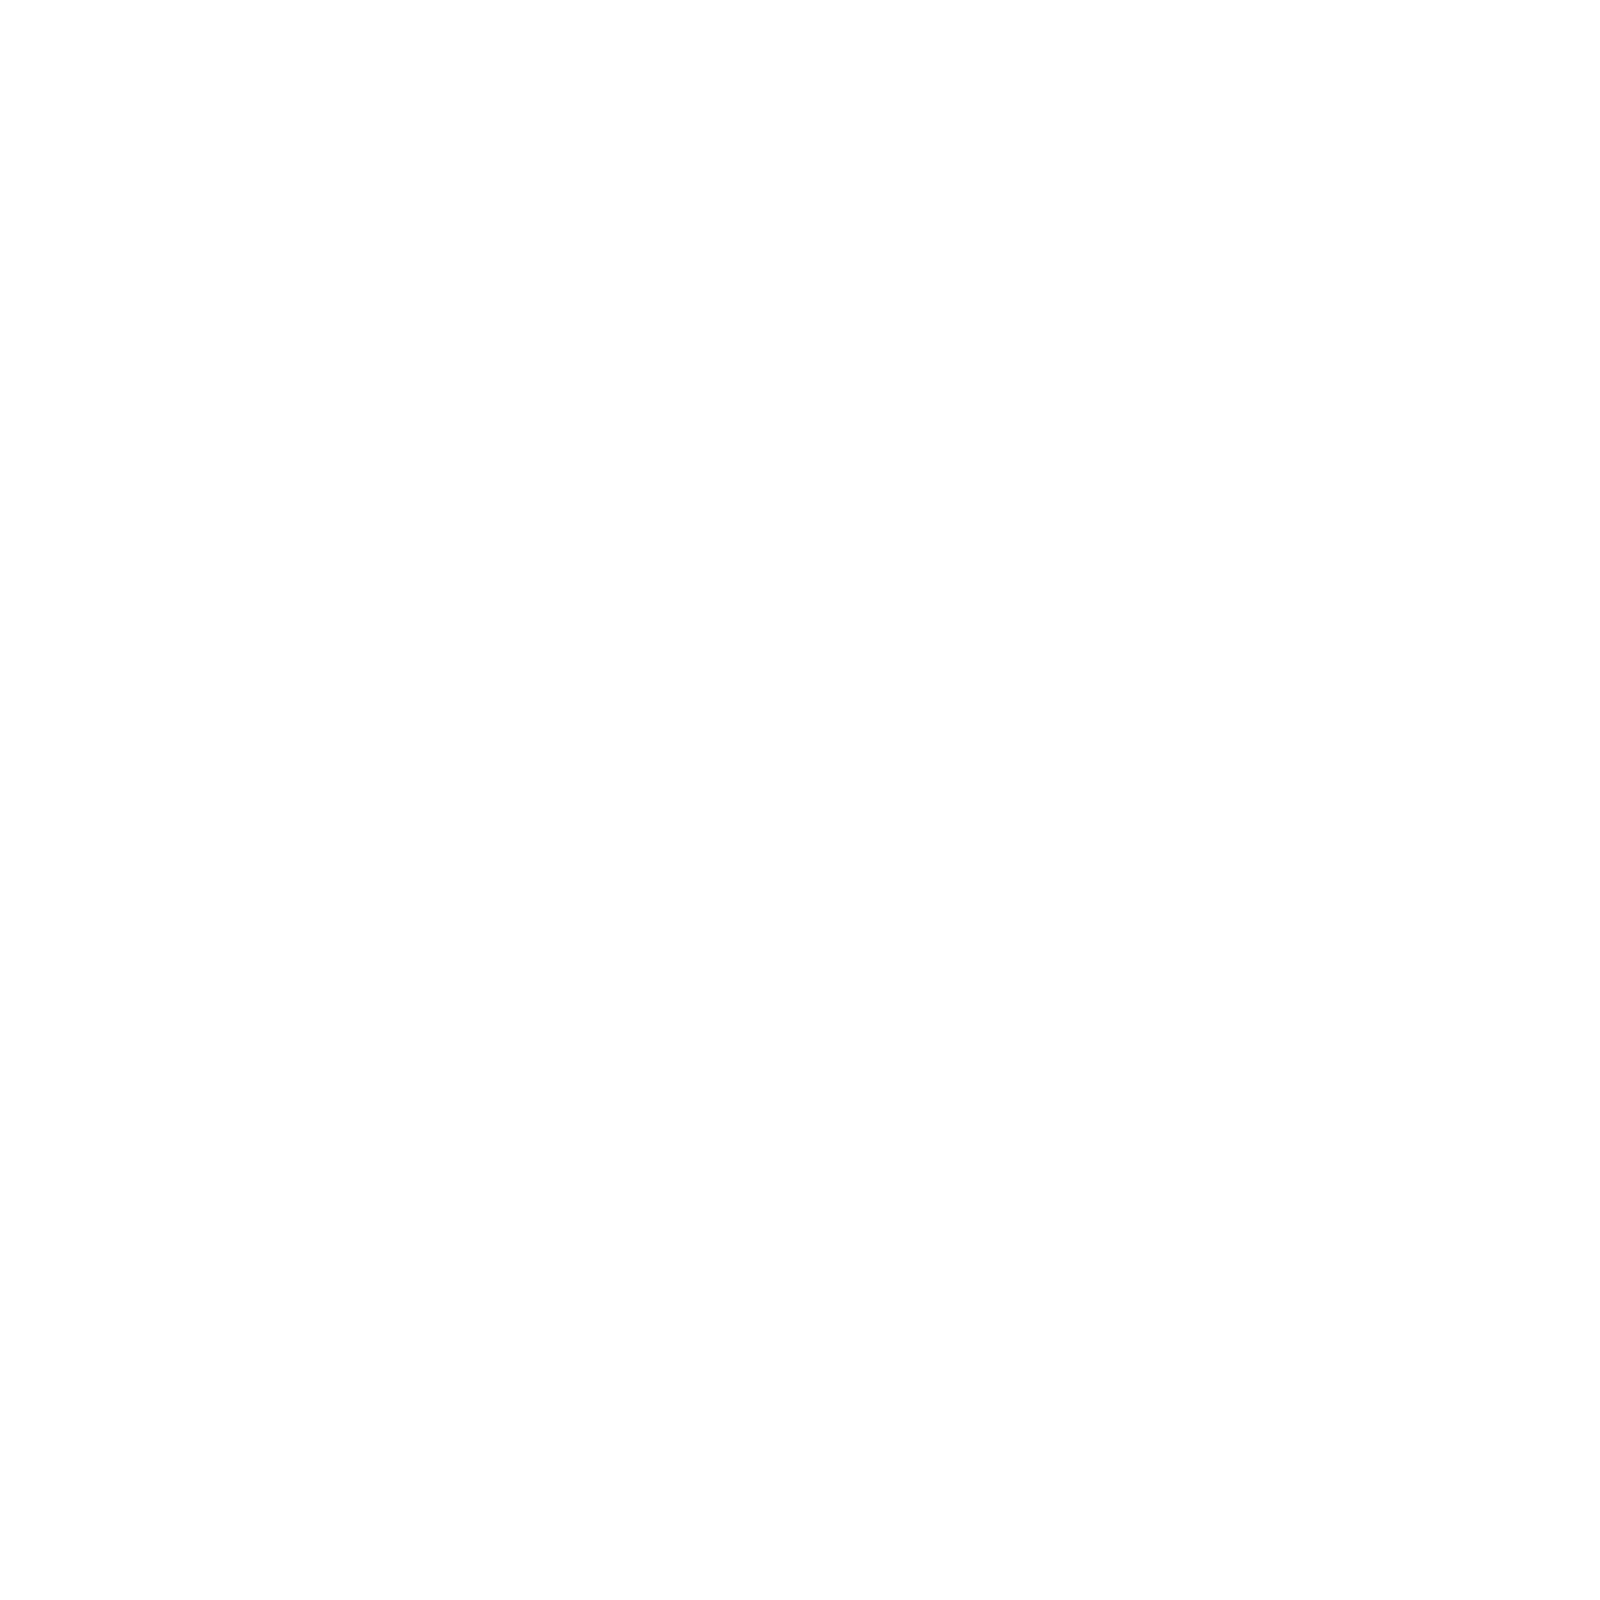

In [4]:
# plot dataset
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [5]:
# name feature and cluster (ground truth) columns
features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
clusters = pd.DataFrame(clusters_arr, columns=["C"])

# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), mv_percent)}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

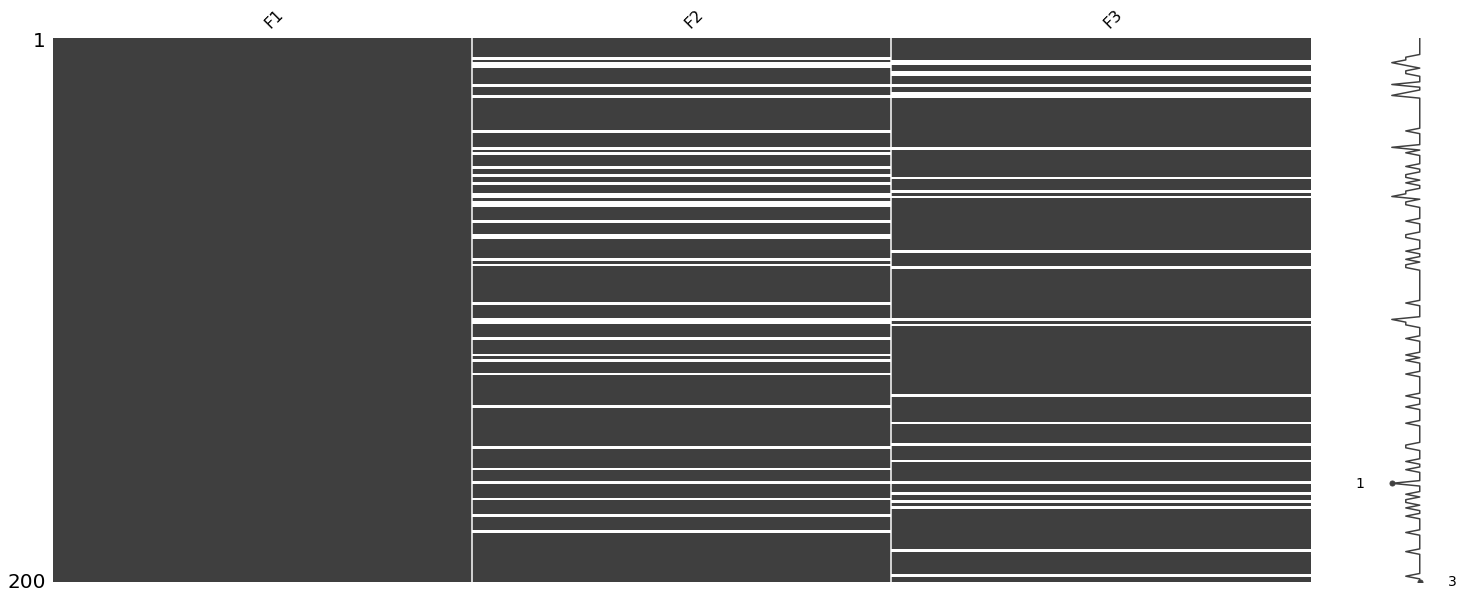

In [6]:
import missingno as msno
%matplotlib inline
# plot missing values
msno.matrix(features_mv)
plt.show()

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [7]:
dbscan_orig = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


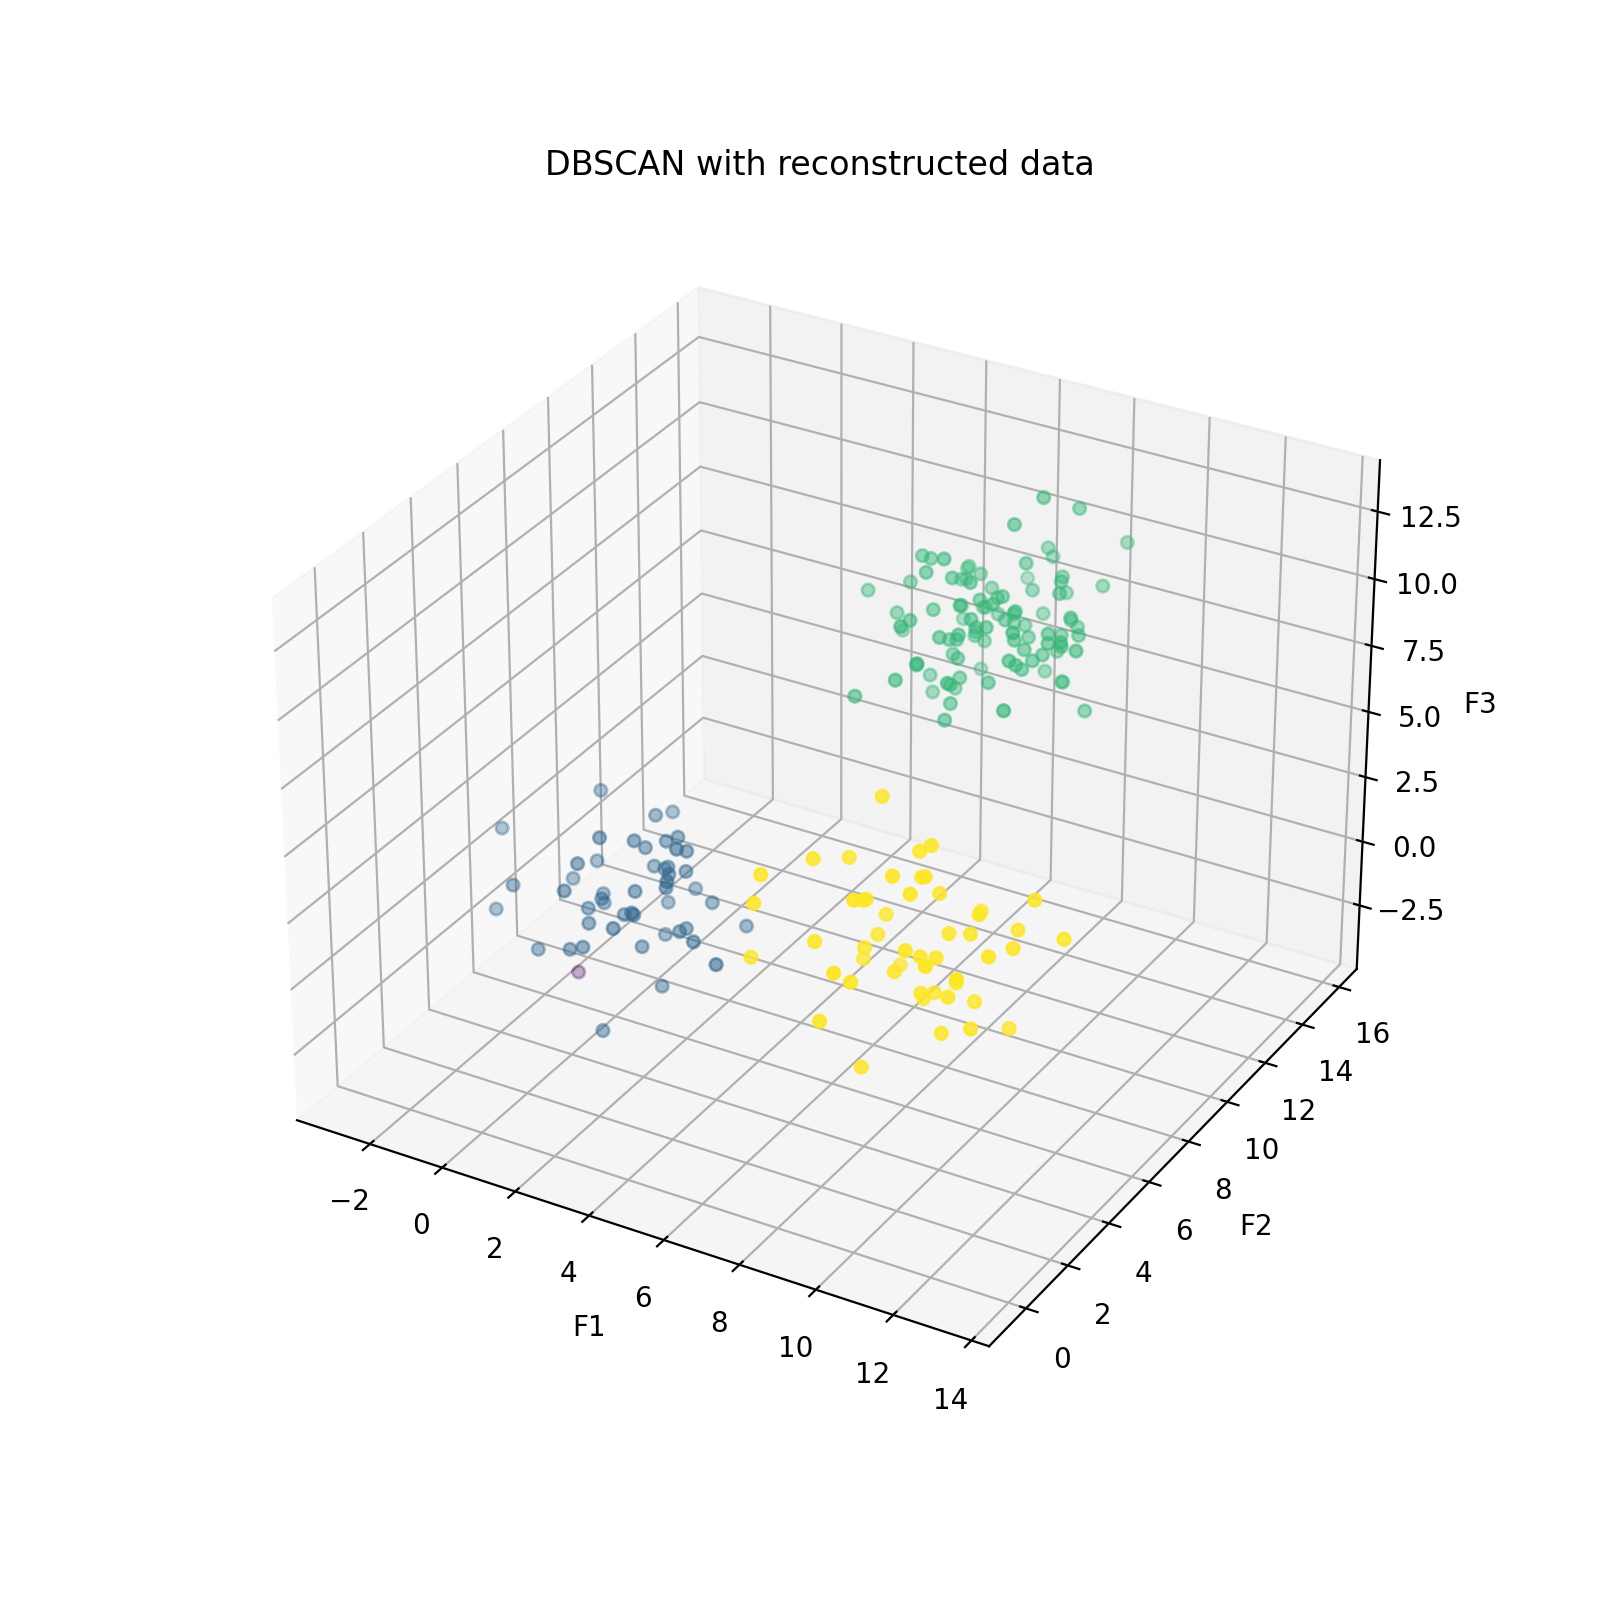

In [8]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()

In [9]:
# get cluster means
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


**custom-loss**\
The loss function for the model fitting shall be customized, depending on the goal to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [10]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        custom_loss = cml# + rmse
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match coods columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # coordinates incl. prediction
        coods = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster, _ in cluster_means[cols].iterrows():
            dist.append([np.linalg.norm(coods.iloc[i] - cluster_means[cols].iloc[cluster]) for i in range(coods.shape[0])])
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(abs(min_dist))
        

Fill missing values (here with TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [11]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
models = []
features_reconstr = []
costs = {}

for run in range(runs):
    costs[run] = []
    for feature in features_to_predict:
        print(f"Run {run+1}, predicting {feature}")
        features_reconstr.append(features_mv.copy())

        # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
        number_of_features = math.ceil(pred_features * (len(features_mv.columns)) - 1)
        features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
        selected_features = features_mv_masked.columns
        
        print(f"Predictions based on features {list(selected_features)}")
        
        # mask other columns' missing values as -1
        features_mv_masked[feature] = features_mv[feature]
        features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(-1)
        
        # separate complete rows as train data
        # separate column with missing values as target
        test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
        train_data = features_mv_masked[features_mv_masked[feature].notna()]
        train_features = train_data.drop(columns=feature).to_numpy()
        train_target = train_data[feature].to_numpy().reshape(-1,1)

        x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)

        # create & train model
        model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                            optimizer_params=dict(lr=2e-2),
                            scheduler_params={"step_size": 2, "gamma": 0.9},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            mask_type='entmax')

        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric=['custom_loss'],
            max_epochs=300, patience=25,
            cluster_means=cluster_means,
            target_feature=feature,
            x_val=x_val,
            y_val=y_val,
        )
        
        # add costs to dict
        costs[run].append(model.best_cost)
        
        # add model to list
        models.append(model)

        # fill missing values with model predictions
        features_reconstr[run].loc[features_reconstr[run][feature].isna(),feature] = [x[0] for x in models[len(models)-1].predict(test_data)]

Run 1, predicting F2
Predictions based on features ['F1', 'F3']
Device used : cpu
             0          1          2        min
0    10.915642  10.339867  16.464534  10.339867
1    53.589140  45.844286  55.673303  45.844286
2     6.923164  11.514330  14.195358   6.923164
3     4.801735  10.549387  13.127932   4.801735
4    27.385036  22.349599  31.014770  22.349599
..         ...        ...        ...        ...
120  69.465518  63.090988  72.088664  63.090988
121  57.637120  50.104973  59.797911  50.104973
122  58.589210  50.954017  60.690573  50.954017
123  86.107436  79.256279  88.423609  79.256279
124  79.818401  73.290342  82.315945  73.290342

[125 rows x 4 columns]
epoch 0  | loss: 35.55313| val_0_custom_loss: 6340.39481|  0:00:00s
             0          1          2        min
0     8.352558   9.619577  14.419844   8.352558
1    40.341653  32.285658  42.218922  32.285658
2     4.598646  11.821025  12.703668   4.598646
3     4.519179  10.647018  12.956081   4.519179
4    21.72

             0          1          2        min
0     6.014975   9.535199  12.719231   6.014975
1    12.931939   1.847520  12.514611   1.847520
2     3.916720  15.369153  10.740919   3.916720
3    21.891155  18.043209  26.899892  18.043209
4     4.913263  14.339312   8.143833   4.913263
..         ...        ...        ...        ...
120   7.408461  10.791891   8.355342   7.408461
121   9.659411   3.611808   7.718686   3.611808
122  10.266199   3.654362   7.964122   3.654362
123   9.820836   8.310350   8.128860   8.128860
124   8.900283  10.567864   8.857956   8.857956

[125 rows x 4 columns]
epoch 13 | loss: 1.46445 | val_0_custom_loss: 713.91157|  0:00:04s
             0          1          2        min
0     5.213407   9.638486  12.184489   5.213407
1    23.182273  14.146763  24.392442  14.146763
2     3.830886  15.302839  10.735014   3.830886
3    22.700377  18.722324  27.641612  18.722324
4     5.277454  14.657950   8.237725   5.277454
..         ...        ...        ...        .

             0          1          2        min
0     2.489391  13.260414   9.307292   2.489391
1    24.073837  15.127452  25.345609  15.127452
2     2.603035  14.295824  10.768125   2.603035
3    16.443256  13.847836  22.028605  13.847836
4     4.663554  14.119953   8.089789   4.663554
..         ...        ...        ...        ...
120  14.840486  22.293286  12.271022  12.271022
121  18.059503   8.829482  18.932388   8.829482
122  21.946864  12.847874  22.977715  12.847874
123  17.154917  23.056625  12.643568  12.643568
124  17.137883  24.152909  13.850913  13.850913

[125 rows x 4 columns]
epoch 26 | loss: 1.05876 | val_0_custom_loss: 973.12611|  0:00:09s
             0          1          2        min
0     2.643268  13.370591   9.304435   2.643268
1    25.065655  16.210062  26.399998  16.210062
2     2.509505  14.206657  10.783574   2.509505
3    15.794968  13.410010  21.467074  13.410010
4     4.390966  13.879085   8.040987   4.390966
..         ...        ...        ...        .

             0          1          2        min
0     2.904000  13.558800   9.305642   2.904000
1    10.041805   7.770272   6.459282   6.459282
2     2.313010  14.000306  10.828367   2.313010
3     7.233736  10.163696  14.705791   7.233736
4     3.242401  12.819891   7.972493   3.242401
..         ...        ...        ...        ...
120  12.637671  20.040847  10.185258  10.185258
121   9.079581   6.993798   5.508242   5.508242
122   9.756905   6.879827   5.988598   5.988598
123  17.570976  23.507578  13.104687  13.104687
124  15.746439  22.711509  12.436185  12.436185

[125 rows x 4 columns]
epoch 40 | loss: 0.80443 | val_0_custom_loss: 674.77213|  0:00:13s
             0          1          2        min
0     2.822940  13.500078   9.304456   2.822940
1    10.052646   7.888207   6.426495   6.426495
2     2.301356  13.986847  10.831745   2.301356
3     6.718477  10.184258  14.355509   6.718477
4     3.225148  12.802828   7.973523   3.225148
..         ...        ...        ...        .

             0          1          2        min
0     1.876757  12.827643   9.345465   1.876757
1    10.206062   8.918147   6.230963   6.230963
2     2.025054  13.514862  10.989279   2.025054
3     2.939502  11.598776  11.963378   2.939502
4     3.044192  12.619612   7.989224   3.044192
..         ...        ...        ...        ...
120   7.744082  14.321408   6.484673   6.484673
121   9.143938   7.950745   5.133469   5.133469
122   9.860123   8.255596   5.522520   5.522520
123  16.331994  22.156900  11.724395  11.724395
124  11.319224  17.882926   8.048876   8.048876

[125 rows x 4 columns]
epoch 53 | loss: 0.69409 | val_0_custom_loss: 615.01428|  0:00:18s
             0          1          2        min
0     1.787133  12.764944   9.354735   1.787133
1    10.214075   8.958005   6.226778   6.226778
2     2.022335  13.503280  10.994177   2.022335
3     2.863528  11.693813  11.901175   2.863528
4     3.013106  12.587214   7.992898   3.013106
..         ...        ...        ...        .

             0          1          2       min
0     0.747390  12.010396   9.549290  0.747390
1    10.246078   9.110258   6.213172  6.213172
2     2.030718  13.230016  11.126146  2.030718
3     2.717216  12.527435  11.513591  2.717216
4     2.643105  12.166597   8.066228  2.643105
..         ...        ...        ...       ...
120   7.265409  10.965891   8.086970  7.265409
121   9.204594   8.375430   5.017694  5.017694
122   9.904684   8.536660   5.465324  5.465324
123  14.122252  19.669699   9.198197  9.198197
124   8.076215  12.257932   6.618789  6.618789

[125 rows x 4 columns]
epoch 67 | loss: 0.54836 | val_0_custom_loss: 591.48249|  0:00:23s
             0          1          2       min
0     0.694053  11.962660   9.567220  0.694053
1    10.251937   9.137053   6.211168  6.211168
2     2.032021  13.225742  11.128475  2.032021
3     2.729281  12.563384  11.502162  2.729281
4     2.623166  12.141109   8.072255  2.623166
..         ...        ...        ...       ...
120   7.232967  

             0          1          2       min
0     0.629504  11.495792   9.783566  0.629504
1    10.199021   8.882491   6.234924  6.234924
2     2.008433  13.390479  11.044748  2.008433
3     2.788746  12.705446  11.460613  2.788746
4     2.324385  11.657558   8.223499  2.324385
..         ...        ...        ...       ...
120   6.997479  11.506920   7.436099  6.997479
121   9.260277   8.681687   4.955403  4.955403
122   9.938242   8.721596   5.435321  5.435321
123  12.423084  17.637909   7.181171  7.181171
124   8.716885  10.710849   8.530310  8.530310

[125 rows x 4 columns]
epoch 80 | loss: 0.58418 | val_0_custom_loss: 591.55132|  0:00:27s
             0          1          2       min
0     0.666090  11.460435   9.803228  0.666090
1    10.192302   8.847874   6.238966  6.238966
2     2.009551  13.345308  11.066503  2.009551
3     2.788768  12.705492  11.460600  2.788768
4     2.308204  11.618125   8.239073  2.308204
..         ...        ...        ...       ...
120   6.938623  

             0          1          2       min
0     1.146916  11.130112  10.012556  1.146916
1    10.124166   8.454972   6.298315  6.298315
2     2.013550  13.455038  11.015163  2.013550
3     2.800340  12.729047  11.454254  2.800340
4     2.235419  11.246393   8.412071  2.235419
..         ...        ...        ...       ...
120   6.929790  11.851200   7.128876  6.929790
121   9.094924   7.406616   5.328431  5.328431
122   9.935498   8.707141   5.437445  5.437445
123  10.814066  15.507945   5.218812  5.218812
124   8.439181  11.013262   7.971591  7.971591

[125 rows x 4 columns]
epoch 93 | loss: 0.51326 | val_0_custom_loss: 578.01407|  0:00:30s
             0          1          2       min
0     1.186070  11.107306  10.028853  1.186070
1    10.121353   8.436633   6.301685  6.301685
2     2.015584  13.468501  11.009211  2.015584
3     2.800742  12.729849  11.454041  2.800742
4     2.236102  11.224319   8.423906  2.236102
..         ...        ...        ...       ...
120   6.926727  

             0          1          2       min
0     1.562604  10.901220  10.188366  1.562604
1    10.063776   7.995963   6.398350  6.398350
2     2.079247  13.662917  10.931252  2.079247
3     2.817198  12.761813  11.445677  2.817198
4     2.266286  11.038374   8.531055  2.266286
..         ...        ...        ...       ...
120   6.932359  11.827570   7.147758  6.932359
121  10.648145   1.492247   9.581400  1.492247
122   9.909820   8.566200   5.460121  5.460121
123   9.780718  13.884655   4.042906  4.042906
124   8.100391  11.851150   6.943242  6.943242

[125 rows x 4 columns]
epoch 106| loss: 0.49076 | val_0_custom_loss: 546.41665|  0:00:34s
             0          1          2       min
0     1.589632  10.887181  10.200085  1.589632
1    10.060873   7.968916   6.405250  6.405250
2     2.091503  13.687498  10.922416  2.091503
3     2.818193  12.763696  11.445193  2.818193
4     2.269503  11.027262   8.537893  2.269503
..         ...        ...        ...       ...
120   6.938366  

             0          1          2       min
0     1.870032  10.746371  10.324279  1.870032
1    10.030620   7.628291   6.501465  6.501465
2     2.239571  13.911938  10.851609  2.239571
3     2.820891  12.768775  11.443891  2.820891
4     2.325253  10.884616   8.630252  2.325253
..         ...        ...        ...       ...
120   6.949423  11.710437   7.245986  6.949423
121  13.207580   2.888580  13.208276  2.888580
122   9.782970   7.548196   5.725544  5.725544
123   9.131421  12.562177   3.603844  3.603844
124   8.084884  12.417496   6.515804  6.515804

[125 rows x 4 columns]
epoch 119| loss: 0.46334 | val_0_custom_loss: 538.89531|  0:00:38s
             0          1          2       min
0     1.888531  10.737373  10.332647  1.888531
1    10.028960   7.604702   6.508757  6.508757
2     2.246798  13.921053  10.849095  2.246798
3     2.821333  12.769604  11.443680  2.821333
4     2.329104  10.876766   8.635587  2.329104
..         ...        ...        ...       ...
120   6.958321  

             0          1          2       min
0     2.075698  10.648243  10.418569  2.075698
1    10.012888   7.307052   6.607574  6.607574
2     2.415507  14.111993  10.802519  2.415507
3     2.828567  12.783019  11.440279  2.828567
4     2.382931  10.780561   8.703206  2.382931
..         ...        ...        ...       ...
120   6.964480  11.634636   7.313811  6.964480
121  13.904434   3.799066  14.084931  3.799066
122  10.347160   3.405112   8.151315  3.405112
123   8.770484  11.409517   3.853381  3.853381
124   8.135602  12.773274   6.330759  6.330759

[125 rows x 4 columns]
epoch 132| loss: 0.45072 | val_0_custom_loss: 518.53595|  0:00:43s
             0          1          2       min
0     2.086069  10.643404  10.423398  2.086069
1    10.012069   7.285304   6.615280  6.615280
2     2.432897  14.129974  10.798715  2.432897
3     2.830862  12.787221  11.439224  2.830862
4     2.387922  10.772620   8.708976  2.387922
..         ...        ...        ...       ...
120   6.970301  

             0          1          2       min
0     2.196416  10.592540  10.475217  2.196416
1    10.040796   6.105126   7.125800  6.105126
2     2.588098  14.281857  10.770395  2.588098
3     2.885946  12.881634  11.416734  2.885946
4     2.443796  10.691345   8.769729  2.443796
..         ...        ...        ...       ...
120   6.987768  11.540760   7.402686  6.987768
121  13.629165   3.442111  13.742006  3.442111
122  12.273688   0.777067  11.466322  0.777067
123   8.674424  10.629046   4.390430  4.390430
124   8.174371  12.946509   6.261614  6.261614

[125 rows x 4 columns]
epoch 145| loss: 0.43451 | val_0_custom_loss: 507.09513|  0:00:48s
             0          1          2       min
0     2.203270  10.589419  10.478462  2.203270
1    10.058087   5.922935   7.219602  5.922935
2     2.592833  14.286294  10.769668  2.592833
3     2.893652  12.894018  11.413956  2.893652
4     2.449372  10.683870   8.775475  2.449372
..         ...        ...        ...       ...
120   6.988363  

             0          1          2       min
0     2.183128  10.598605  10.468934  2.183128
1    10.638311   3.434831   8.832051  3.434831
2     2.633661  14.324174  10.763688  2.633661
3     2.971691  13.011232  11.389572  2.971691
4     2.497818  10.622621   8.823598  2.497818
..         ...        ...        ...       ...
120   7.006777  11.476650   7.466625  7.006777
121  13.354271   3.082069  13.395244  3.082069
122  13.379859   2.381082  13.000693  2.381082
123   8.697667  10.106614   4.908877  4.908877
124   8.198720  13.039794   6.229786  6.229786

[125 rows x 4 columns]
epoch 158| loss: 0.42332 | val_0_custom_loss: 491.51939|  0:00:53s
             0          1          2       min
0     2.177528  10.601166  10.466289  2.177528
1    10.786316   3.051372   9.132383  3.051372
2     2.637561  14.327759  10.763143  2.637561
3     2.980536  13.023741  11.387171  2.980536
4     2.500926  10.618892   8.826589  2.500926
..         ...        ...        ...       ...
120   7.004026  

             0          1          2       min
0     1.963480  10.701270  10.366777  1.963480
1    11.761584   1.389770  10.813720  1.389770
2     2.672546  14.359664  10.758449  2.672546
3     3.072687  13.147199  11.365500  3.072687
4     2.601980  10.507618   8.919149  2.601980
..         ...        ...        ...       ...
120   7.025614  11.420467   7.524921  7.025614
121  13.110239   2.759723  13.083416  2.759723
122  13.891368   3.103067  13.670947  3.103067
123   8.758545   9.772141   5.309555  5.309555
124   8.211247  13.084622   6.215805  6.215805

[125 rows x 4 columns]
epoch 171| loss: 0.41123 | val_0_custom_loss: 468.75897|  0:00:59s
             0          1          2       min
0     1.946351  10.709472  10.358944  1.946351
1    11.848664   1.322667  10.948621  1.322667
2     2.675539  14.362375  10.758063  2.675539
3     3.070561  13.144471  11.365939  3.070561
4     2.606286  10.503237   8.922929  2.606286
..         ...        ...        ...       ...
120   7.025407  

             0          1          2       min
0     1.586699  10.888700  10.198812  1.586699
1    12.307167   1.283204  11.633670  1.283204
2     2.688827  14.374369  10.756380  2.688827
3     3.060659  13.131703  11.368021  3.060659
4     2.727238  10.389036   9.025260  2.727238
..         ...        ...        ...       ...
120   7.045955  11.365861   7.583689  7.045955
121  12.881476   2.455762  12.787321  2.455762
122  13.953245   3.188881  13.750739  3.188881
123   8.833923   9.517792   5.653989  5.653989
124   8.221097  13.118619   6.205763  6.205763

[125 rows x 4 columns]
epoch 184| loss: 0.39985 | val_0_custom_loss: 454.59125|  0:01:04s
             0          1          2       min
0     1.555641  10.904851  10.185353  1.555641
1    12.348028   1.303864  11.692937  1.303864
2     2.686991  14.372716  10.756610  2.686991
3     3.060544  13.131554  11.368045  3.060544
4     2.739959  10.377871   9.035671  2.739959
..         ...        ...        ...       ...
120   7.047110  

             0          1          2       min
0     1.131231  11.139341  10.006033  1.131231
1    12.552668   1.450931  11.986009  1.450931
2     2.667919  14.355470  10.759050  2.667919
3     3.056159  13.125863  11.368985  3.056159
4     2.880249  10.262887   9.147393  2.880249
..         ...        ...        ...       ...
120   7.069394  11.308913   7.647280  7.069394
121  12.686942   2.196682  12.532364  2.196682
122  13.892803   3.105061  13.672801  3.105061
123   8.912568   9.321194   5.947095  5.947095
124   8.224297  13.129452   6.202665  6.202665

[125 rows x 4 columns]
epoch 197| loss: 0.38753 | val_0_custom_loss: 446.19515|  0:01:09s
             0          1          2       min
0     1.100553  11.157556   9.993280  1.100553
1    12.547418   1.446389  11.978564  1.446389
2     2.665536  14.353306  10.759362  2.665536
3     3.054755  13.124036  11.369289  3.054755
4     2.893257  10.252882   9.157517  2.893257
..         ...        ...        ...       ...
120   7.071659  

             0          1          2        min
0     9.773227   9.284593  13.328609   9.284593
1     9.555952   8.286300  14.070313   8.286300
2     8.182025  12.068854   6.237956   6.237956
3    13.622807  12.365333  10.355054  10.355054
4    56.154276  47.711967  52.107185  47.711967
..         ...        ...        ...        ...
127  87.579870  79.200085  82.930792  79.200085
128  14.536486  13.547605  10.270677  10.270677
129  77.360182  69.126997  72.832255  69.126997
130  88.498632  80.035599  84.204267  80.035599
131  26.491809  18.492521  24.188409  18.492521

[132 rows x 4 columns]
epoch 9  | loss: 2.45558 | val_0_custom_loss: 5121.50433|  0:00:03s
             0          1          2        min
0     9.179872   9.217936  13.093578   9.179872
1    10.356788   8.333763  14.363035   8.333763
2     7.086523  12.494321   5.987859   5.987859
3    11.708717  11.750325   8.698709   8.698709
4    41.028914  32.398147  36.979939  32.398147
..         ...        ...        ...        

             0          1          2        min
0     6.806697   9.398128  12.420612   6.806697
1     8.955628   8.325396  13.884406   8.325396
2     7.301861  12.384080   6.001256   6.001256
3     7.500339  11.831409   6.037272   6.037272
4    25.275761  16.219969  21.277878  16.219969
..         ...        ...        ...        ...
127  29.720890  20.739010  23.781980  20.739010
128   8.183777  13.358923   5.585013   5.585013
129  15.001566   7.607710   8.215840   7.607710
130  28.846705  19.317240  24.021011  19.317240
131  13.858559   6.390148  13.425640   6.390148

[132 rows x 4 columns]
epoch 22 | loss: 1.07671 | val_0_custom_loss: 1373.19579|  0:00:08s
             0          1          2        min
0     7.580234   9.257332  12.588965   7.580234
1     8.456490   8.411659  13.754383   8.411659
2     7.219329  12.424418   5.993554   5.993554
3     7.343818  11.888307   5.997716   5.997716
4    23.901208  14.783956  19.918763  14.783956
..         ...        ...        ...        

             0          1          2       min
0     4.982795  10.089120  12.261984  4.982795
1     5.793099  10.191917  13.673938  5.793099
2     6.999498  12.543800   5.989011  5.989011
3     7.191947  11.949188   5.967015  5.967015
4     8.696752   5.472117   7.452292  5.472117
..         ...        ...        ...       ...
127  12.800138   8.741430   5.483863  5.483863
128   8.332600  13.267035   5.584226  5.584226
129  11.011611   7.710655   4.087077  4.087077
130  11.619138   5.334718   7.558984  5.334718
131   5.928275   6.840633  10.259225  5.928275

[132 rows x 4 columns]
epoch 35 | loss: 0.73693 | val_0_custom_loss: 726.26865|  0:00:12s
             0          1          2       min
0     4.806064  10.189013  12.268463  4.806064
1     5.697111  10.369595  13.721000  5.697111
2     6.965618  12.563919   5.990588  5.990588
3     7.077726  11.998975   5.949353  5.949353
4     8.513366   5.971383   7.539330  5.971383
..         ...        ...        ...       ...
127  12.725814  

             0          1          2       min
0     3.867256  10.893676  12.407254  3.867256
1     5.441680  11.465279  14.102638  5.441680
2     7.443133  12.320035   6.021185  6.021185
3     7.424734  11.858182   6.017208  6.017208
4     8.126025   8.313431   8.394327  8.126025
..         ...        ...        ...       ...
127  12.432441   9.440588   5.644008  5.644008
128   8.611424  13.123288   5.623508  5.623508
129  10.704847   8.109543   4.070241  4.070241
130  10.692900   8.948633   8.533941  8.533941
131   5.379497   8.956558  10.907747  5.379497

[132 rows x 4 columns]
epoch 48 | loss: 0.65492 | val_0_custom_loss: 746.13554|  0:00:16s
             0          1          2       min
0     3.898290  10.863115  12.398601  3.898290
1     5.441736  11.446076  14.094801  5.441736
2     7.456469  12.314296   6.023482  6.023482
3     7.442923  11.851621   6.021874  6.021874
4     8.126144   8.286590   8.381026  8.126144
..         ...        ...        ...       ...
127  12.440165  

             0          1          2       min
0     4.002753  10.765627  12.372351  4.002753
1     5.444741  11.590176  14.154478  5.444741
2     7.005343  12.540379   5.988804  5.988804
3     7.064636  12.004913   5.947645  5.947645
4     8.126086   8.296956   8.386154  8.126086
..         ...        ...        ...       ...
127  12.629183   9.014327   5.508995  5.508995
128   8.388611  13.235415   5.588168  5.588168
129  10.861123   7.889680   4.058671  4.058671
130  10.694609   9.104444   8.617486  8.617486
131   5.382784   9.114518  10.974161  5.382784

[132 rows x 4 columns]
epoch 62 | loss: 0.54545 | val_0_custom_loss: 743.42675|  0:00:20s
             0          1          2       min
0     4.062003  10.713562  12.359211  4.062003
1     5.444011  11.573916  14.147645  5.444011
2     6.970761  12.560832   5.990306  5.990306
3     7.026785  12.022363   5.943084  5.943084
4     8.126493   8.247580   8.361818  8.126493
..         ...        ...        ...       ...
127  12.650689  

             0          1          2       min
0     4.485474  10.391179  12.293380  4.485474
1     5.441785  11.439883  14.092282  5.441785
2     6.457326  12.942387   6.111555  6.111555
3     6.385664  12.395528   5.969007  5.969007
4     8.158533   7.644070   8.084282  7.644070
..         ...        ...        ...       ...
127  12.750896   8.813248   5.484659  5.484659
128   8.138494  13.389412   5.588842  5.588842
129  11.518283   7.275960   4.370532  4.370532
130  10.694617   8.763817   8.438006  8.438006
131   5.380763   8.843753  10.861666  5.380763

[132 rows x 4 columns]
epoch 76 | loss: 0.46083 | val_0_custom_loss: 743.79934|  0:00:24s
             0          1          2       min
0     4.502828  10.379452  12.291551  4.502828
1     5.442073  11.418145  14.083467  5.442073
2     6.436392  12.962139   6.121625  6.121625
3     6.333945  12.433885   5.981728  5.981728
4     8.162477   7.603670   8.067080  7.603670
..         ...        ...        ...       ...
127  12.752965  

## 3. Complete Dataset
Costs for each run

In [12]:
costs

{0: [445.38924650325066, 726.2686506512599]}

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [13]:
cost_totals = [sum([x**2 for x in c]) for _, c in costs.items()]
best_model = cost_totals.index(min(cost_totals))
features_final = features_reconstr[best_model]
print(f"Best model: run {best_model} with custom losses {costs[best_model]} for features {list(features_to_predict)}")

Best model: run 0 with custom losses [445.38924650325066, 726.2686506512599] for features ['F2', 'F3']


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


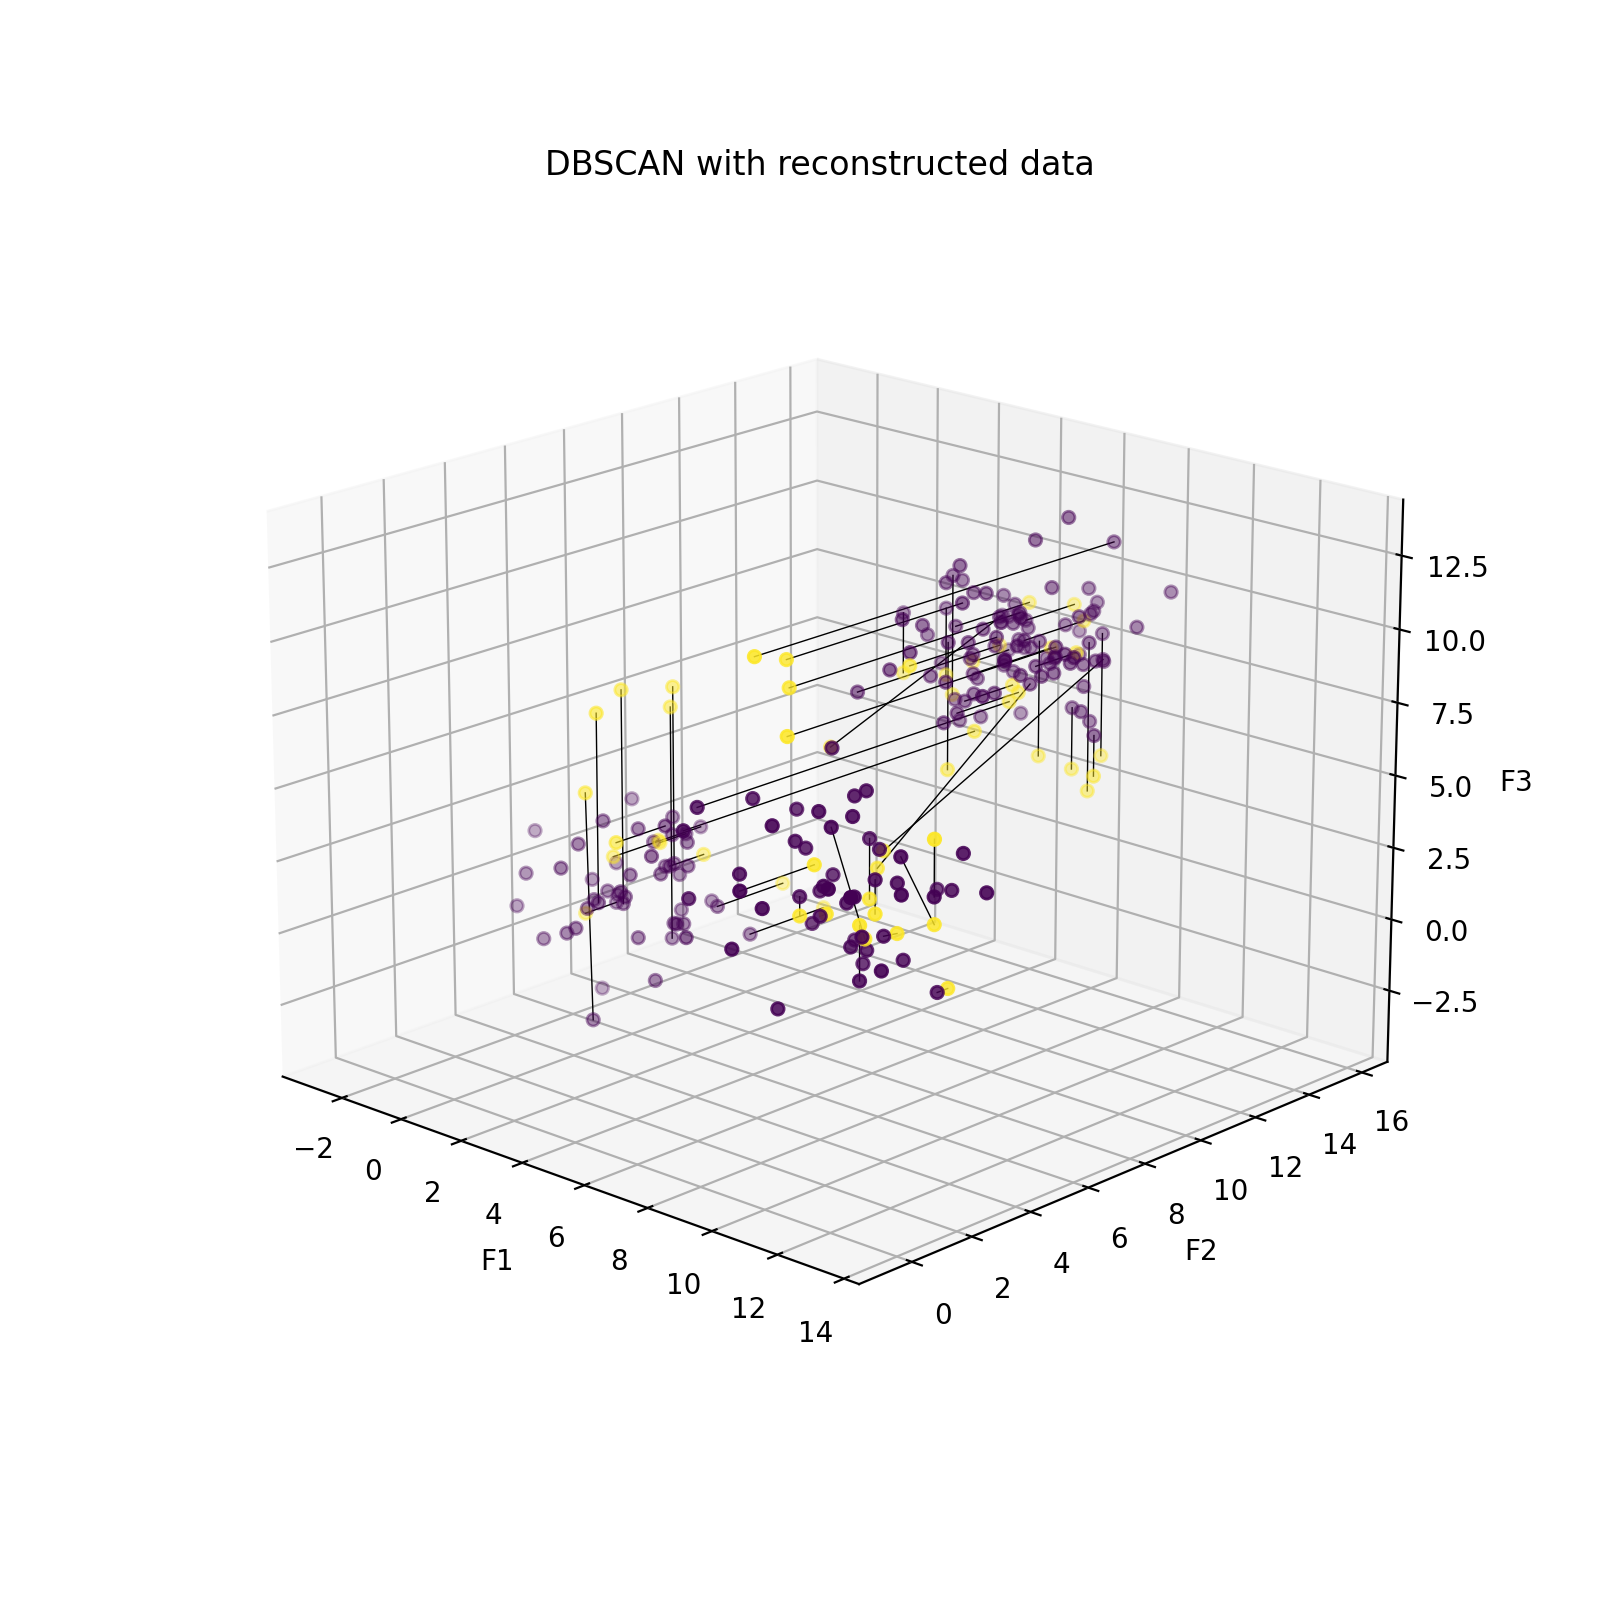

<function matplotlib.pyplot.show(block=None)>

In [14]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_final[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_final[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show

## 4. Clustering

In [19]:
# apply clustering
dbscan_reconstr = DBSCAN(eps=eps, min_samples=min_samples).fit(features_final)
clusters_reconstr = dbscan_reconstr.labels_

<IPython.core.display.Javascript object>


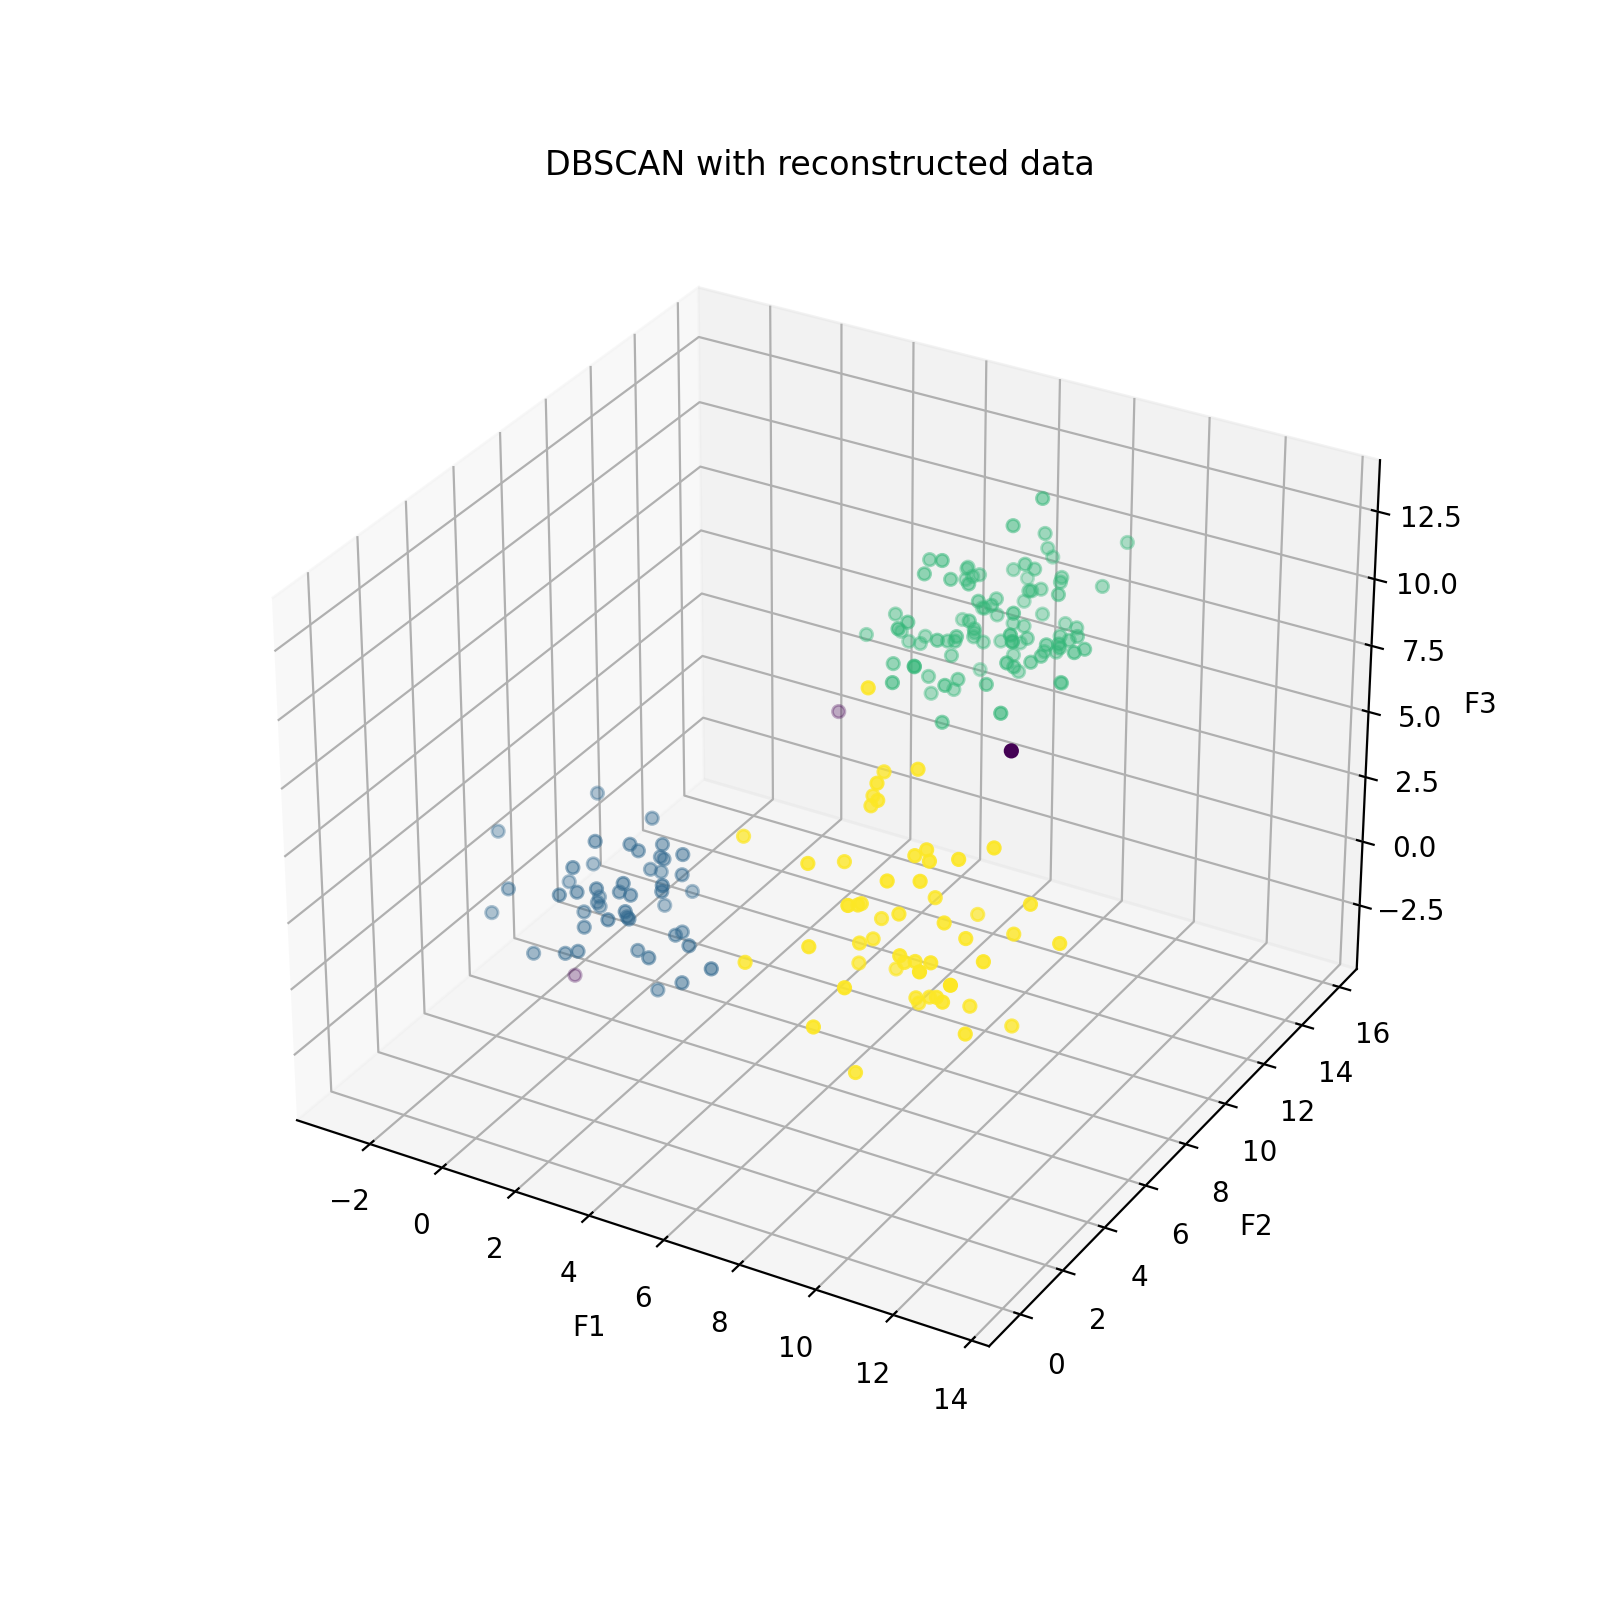

In [20]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_final.iloc[:, 0], features_final.iloc[:, 1], features_final.iloc[:, 2], c=clusters_reconstr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()

## 5. Cluster Performance
### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots

<IPython.core.display.Javascript object>


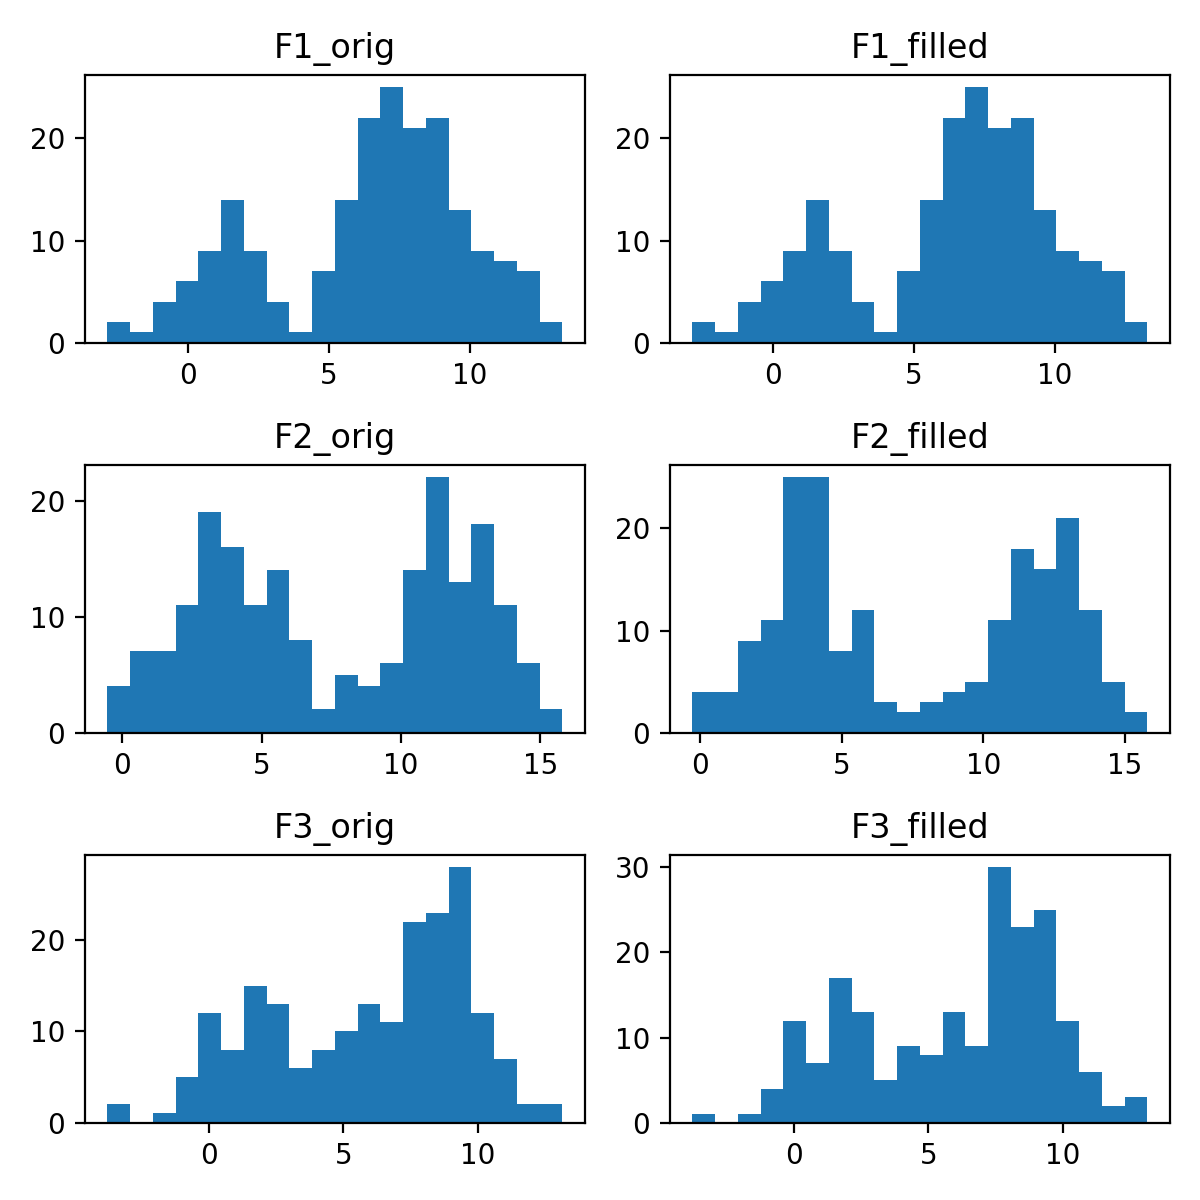

In [21]:
# plot distributions
bins = 20
n_feat = len(features_final.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_final.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_final[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()

#### 5.1.2 KL Divergence
Based on implementation from https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula

In [22]:
# calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr

# calculate probabilities
def probability_dist(x, y, bins):
    # histogram
    hist_xy = np.histogram2d(x, y, bins=bins)[0]

    # compute marginals
    hist_xy = hist_xy + sys.float_info.min # prevent division with 0
    hist_xy = hist_xy / np.sum(hist_xy)
    hist_x = np.sum(hist_xy, axis=1)
    hist_y = np.sum(hist_xy, axis=0)
    return(hist_x, hist_y)

# calculate kl divergence
for n, feature in enumerate(features_final):
    dist1, dist2 = probability_dist(features[feature], features_final[feature], bins)
    print(f"KL divergence {feature}_orig to {feature}_filled: {sum(rel_entr(dist1, dist2))}")
    print(f"KL divergence {feature}_filled to {feature}_orig: {sum(rel_entr(dist2, dist1))}")
    print("")
    

KL divergence F1_orig to F1_filled: 0.0
KL divergence F1_filled to F1_orig: 0.0

KL divergence F2_orig to F2_filled: 0.047064060806200916
KL divergence F2_filled to F2_orig: 0.043422613496441456

KL divergence F3_orig to F3_filled: 0.014506068208007752
KL divergence F3_filled to F3_orig: 0.014637545625476752



### 5.2 Cluster Performance
#### 5.3 Noise

In [23]:
print(f"DBSCAN noise orig_data: {sum(clusters_orig == -1)}")
print(f"DBSCAN noise reconstr_data:{sum(clusters_reconstr == -1)}")

DBSCAN noise orig_data: 1
DBSCAN noise reconstr_data:3


#### 5.4 Silhouette Score

In [24]:
from sklearn.metrics import silhouette_score

print(f"Silhouette Score orig_data: {silhouette_score(features, np.ravel(clusters))}")
print(f"Silhouette Score filled_data: {silhouette_score(features_final, clusters_reconstr)}")

Silhouette Score orig_data: 0.6849069820802122
Silhouette Score filled_data: 0.6467649021341599
